# Using APOC for object classification in google colab
In this notebook, we demonstrate how to use the accelerated-pixel-and-object-classifier ([APOC](https://github.com/haesleinhuepf/apoc#accelerated-pixel-and-object-classification-apoc)) to classify nuclei from an example fluorescence image.



## Getting a GPU

Before executing this notebook in google colab, please swith the runtime to `GPU`. After that, at the top-right, click on 'Connect'.

<img src="https://github.com/BiAPoL/blog/raw/master/docs/robert_haase/clesperanto_google_colab/clesperanto_colab/colab2.png" width="500">

Additionally now, also at the top-right, you should see two very small graphs named  'RAM' and 'Disk'. Click on them to better visualize what computational resources are available for you.

## Installing additional packages

Google colab environment already comes with some popular scientific packages. In case you need to install extra packages to the environment, you can do so with `pip` as shown below.

**So, if running this from google colab**, execute the following line. It installs [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype#py-clesperanto), [apoc](https://github.com/haesleinhuepf/apoc#accelerated-pixel-and-object-classification-apoc) and [stackview](https://github.com/haesleinhuepf/stackview#stackview-) into your colab kernel.

In [ ]:
!pip install pyclesperanto_prototype apoc stackview ipycanvas==0.11


## Importing packages

The next cell imports the necessary packages we use in this notebook and selects a specific backend for pyclesperanto. 


In [2]:
import apoc
import numpy as np
import pyclesperanto_prototype as cle
from skimage.io import imread
from skimage.data import human_mitosis
import stackview

*Notice: due to a recent [opencl support on Google colab issue](https://github.com/clEsperanto/pyclesperanto_prototype/issues/300), it is necessary to change the backend to 'cupy' as done by running the cell below.*

In [3]:
cle.select_device("cupy")

'cupy backend (experimental)'

Additionally, in order to enable widgets from [stackview](https://github.com/haesleinhuepf/stackview#stackview-) in colab, run the cell below.

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

## Loading image
We will be using the `human_mitosis` example image from `scikit-image`.
We can load it and push it to the GPU as shown below.

/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier0/_cuda_backend.py:39: UserWarning: clesperanto's cupy / CUDA backend is experimental. Please use it with care. The following functions are known to cause issues in the CUDA backend:
affine_transform, apply_vector_field, create(uint64), create(int32), create(int64), resample, scale, spots_to_pointlist
  warnings.warn("clesperanto's cupy / CUDA backend is experimental. Please use it with care. The following functions are known to cause issues in the CUDA backend:\n" +


experimental clesperanto CUDAArray([[ 8.  8.  8. ... 63. 78. 75.]
 [ 8.  8.  7. ... 67. 71. 71.]
 [ 9.  8.  8. ... 53. 64. 66.]
 ...
 [ 8.  9.  8. ... 17. 24. 59.]
 [ 8.  8.  8. ... 17. 22. 55.]
 [ 8.  8.  8. ... 16. 18. 38.]], dtype=float32)
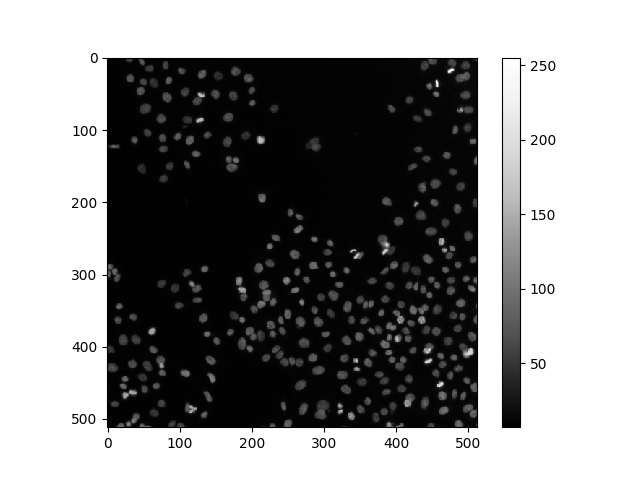
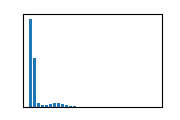

In [5]:
image = cle.push(human_mitosis())
image

## Segmenting nuclei
We apply the [`voronoi_otsu_labeling`](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html#voronoi-otsu-labeling) function from `pyclesperanto` to segment the nuclei and generate a labeled image.

experimental clesperanto CUDAArray([[  0   0   0 ... 318 318 318]
 [  0   0   0 ... 318 318 318]
 [  0   0   0 ... 318 318 318]
 ...
 [  0   0   0 ...   0   0 324]
 [  0   0   0 ...   0   0 324]
 [  0   0   0 ...   0   0 324]], dtype=uint32)
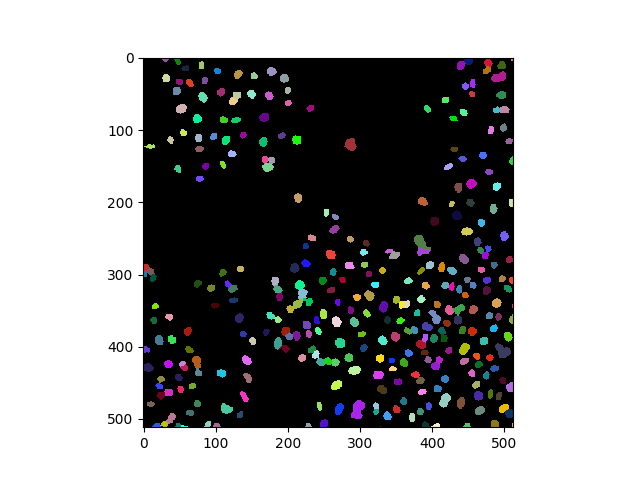

In [6]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=2, outline_sigma=1)
labels

### Visualizing results

We can visualize both the original image and the segmentation together with `cle.imshow` by adding some extra arguments to it. We set `continue_drawing` to `True` for the original image and we set `alpha` to `0.5` for the label image.

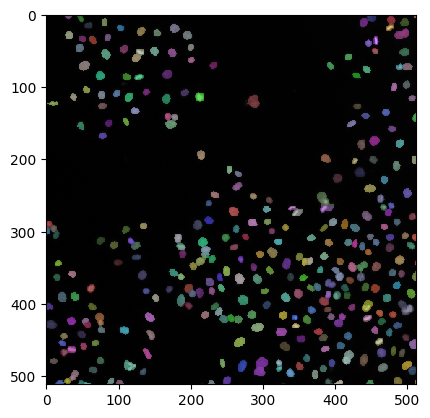

In [7]:
cle.imshow(image, continue_drawing=True)
cle.imshow(labels, labels=True, alpha=0.5)

Another visualization option is to use the `curtain` function from stackview which shows both images with a slider.

In [8]:
stackview.curtain(np.asarray(image), np.asarray(labels), continuous_update=False, alpha=0.5)

## Loading stored annotations
We load a previously annotated labeled image for the objects we segmented in order to classify them. Again, we display these annotations half transparent on top of the original image.

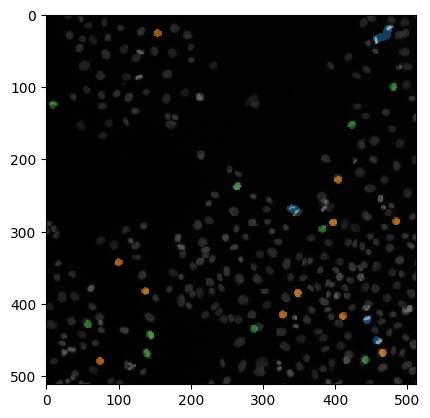

In [10]:
annotations = cle.push(imread('https://github.com/zoccoler/GPU_Accelerated_Image_Processing_on_Cloud_NEUBIAS_Defragmentation_TS2_2023/raw/main/data/objects_annotations.tif'))
cle.imshow(image, continue_drawing=True)
cle.imshow(annotations, labels=True, alpha=0.5)

In this example, we annotated three classes: 

1. brighter objects (blue);

2. roundish objects (orange);

3. elongated objects (green);

## Training an object classifier

### Connecting google drive

For storing the model we are about to train, we need to connect to google drive. For that, run the cell below.

The procedure involves creating an authorization code. 
In order to generate it, click on the provided link and follow the instructions.
See more detailed instructions [here](https://biapol.github.io/blog/robert_haase/clesperanto_google_colab/readme.html#step-5-connecting-google-drive).

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Creating a classifier

We create a new classifier which will be stored in the specified path in google drive.

In [14]:
# Create an object classifier
cl_filename_object_classifier = "gdrive/MyDrive/object_classifier.cl"
apoc.erase_classifier(cl_filename_object_classifier)
classifier = apoc.ObjectClassifier(cl_filename_object_classifier)

### Training the classifier

We define a few features of interest and train the classifier. We provide as argument the specified features, the segmentation results (labels), the loaded annotations and the original image ([see a full example here](https://github.com/haesleinhuepf/apoc/blob/main/demo/demo_object_classification.ipynb)).

In [15]:
# Define some features
features = 'area,min_intensity,max_intensity,standard_deviation_intensity,mean_intensity,mean_max_distance_to_centroid_ratio,max_distance_to_centroid'

# train it
classifier.train(features, labels, annotations, image)

The pre-trained classifier is saved in google drive.

### Running predictions

Now, we predict the results from the object classifier and display them.

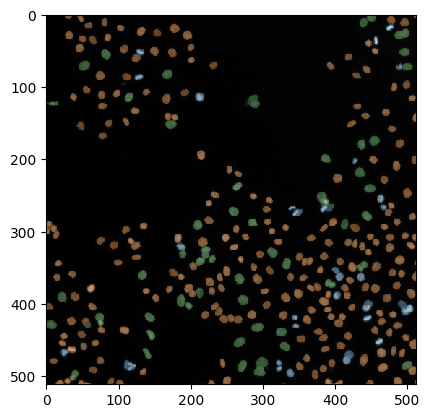

In [16]:
# determine object classification
classification_result = classifier.predict(labels, image)

# Display results over original image
cle.imshow(image, continue_drawing=True)
cle.imshow(classification_result, labels=True, alpha=0.3)